<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Solale Mohammadi
### Student Number : 98106015
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [97]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [98]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [99]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


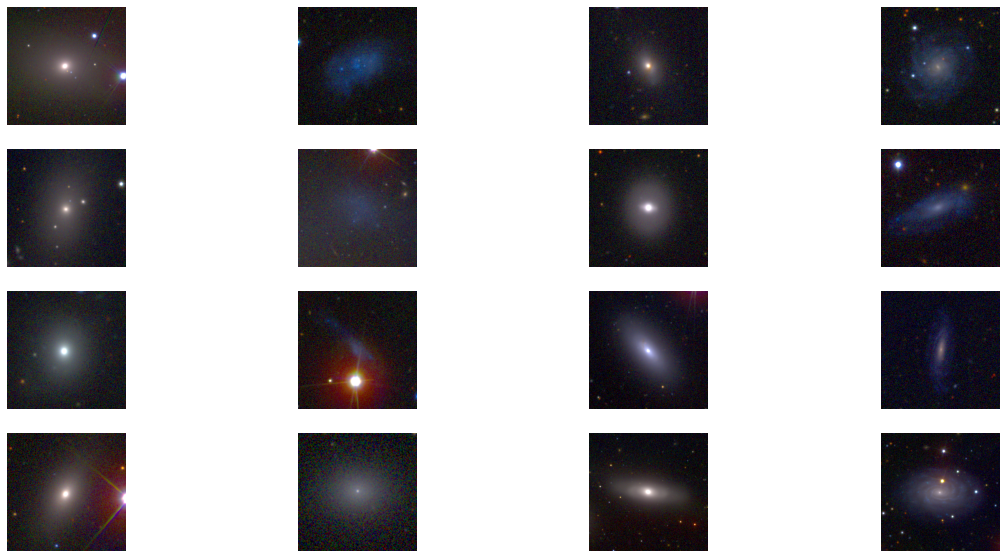

In [100]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################
import torchvision
import torchvision.transforms as T

def sample(X, y, samples):
    unique_ys = np.unique(y, axis=0)
    result = {}
    for unique_y in unique_ys:
        result[unique_y] = []
        val_indices = np.argwhere(y == unique_y).flatten()
        random_samples = np.random.choice(val_indices, samples, replace=False)
        result[unique_y] = X[random_samples]
    return result


samples = sample(np.array(list(df['name'])), np.array(list(df['class_name'])), 4)
fig, ax = plt.subplots(4, 4, figsize=(20, 10))
for i in range(4):
    for j, k in enumerate(samples.keys()):
        s = samples[k][i]
        image = torchvision.io.read_image(f'./efigi-1.6/png/{s}.png')
        T.ToPILImage()(image)
        ax[i, j].imshow(image.T)
        ax[i, j].axis('off')


In [101]:
df.shape

(4458, 3)

In [102]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
val_mask = np.random.rand(len(train)) < 0.8
val = train[~val_mask]
train = train[val_mask]

# Define Dataset (20 Points)

In [103]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################

class GalaxyDataSet(Dataset):
    def __init__(self, img_labels, image_names, transform=None, target_transform=None):
        self.img_labels = list(img_labels)
        self.image_names = list(image_names)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = f'./efigi-1.6/png/{self.image_names[idx]}.png'
        image = torchvision.io.read_image(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [104]:
train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomCrop(255, padding=10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
     transforms.Normalize((0, 0, 0), (1, 1, 1))])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
])

In [105]:
train_dataset = GalaxyDataSet(
    train['class_label'], 
    train['name'], 
    train_transform)

test_dataset = GalaxyDataSet(
    test['class_label'], 
    test['name'], 
    test_transform)

val_dataset = GalaxyDataSet(
    val['class_label'], 
    val['name'], 
    train_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                           shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, 
                                                shuffle=False, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16,
                                          shuffle=False, num_workers=2)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Define Model (20 Points)

In [106]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class ClassifierModel(nn.Module):
    def __init__(self, input_size = 3*255*255):
        super(ClassifierModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512,4)
    
    def forward(self, x):
        x = x.view(-1, 3*255*255)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train Model (30 Points)

In [107]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################
import torch.optim as optim

model = ClassifierModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [108]:
import copy

train_loss, train_accuracy, validation_loss, validation_accuracy = [], [], [], []

best_result = (0.0,0.0)
best_net = None

for epoch in range(15):
    running_loss = 0.0
    correct = 0
    for data in tqdm(train_loader):
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, p = torch.max(outputs, 1)
        correct += (p == labels).sum().item()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_dataset)
    avg_accuracy = correct / len(train_dataset)
    train_loss.append(avg_loss)
    train_accuracy.append(avg_accuracy)
    model.eval()
    with torch.no_grad():
        loss_val = 0.0
        correct_val = 0
        for data in validation_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels)
            _, p = torch.max(outputs, 1)
            correct_val += (p == labels).sum().item()
            loss_val += loss.item()
        avg_loss_val = loss_val / len(val_dataset)
        avg_accuracy_val = correct_val / len(val_dataset)
        validation_loss.append(avg_loss_val)
        validation_accuracy.append(avg_accuracy_val)
    if (avg_accuracy_val, avg_loss_val) > best_result:
        best_result = (avg_accuracy_val, avg_loss_val)
        best_net = copy.deepcopy(model)
    model.train()
    scheduler.step(avg_loss_val)
    print('[epoch %d] Train Loss: %.4f Train Accuracy: %.4f Validation Loss: %.4f Validation Accuracy: %.4f' % (
        epoch + 1, avg_loss, avg_accuracy, avg_loss_val, avg_accuracy_val))

100%|██████████| 182/182 [00:17<00:00, 10.47it/s]
/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[epoch 1] Train Loss: 0.0525 Train Accuracy: 0.7466 Validation Loss: 0.0424 Validation Accuracy: 0.7612


100%|██████████| 182/182 [00:16<00:00, 11.35it/s]


[epoch 2] Train Loss: 0.0459 Train Accuracy: 0.7417 Validation Loss: 0.0491 Validation Accuracy: 0.7191


100%|██████████| 182/182 [00:16<00:00, 11.36it/s]


[epoch 3] Train Loss: 0.0418 Train Accuracy: 0.7541 Validation Loss: 0.0403 Validation Accuracy: 0.7354


100%|██████████| 182/182 [00:16<00:00, 11.28it/s]


[epoch 4] Train Loss: 0.0396 Train Accuracy: 0.7590 Validation Loss: 0.0590 Validation Accuracy: 0.6269


100%|██████████| 182/182 [00:16<00:00, 11.32it/s]


[epoch 5] Train Loss: 0.0389 Train Accuracy: 0.7610 Validation Loss: 0.0406 Validation Accuracy: 0.7503


100%|██████████| 182/182 [00:16<00:00, 11.33it/s]


[epoch 6] Train Loss: 0.0410 Train Accuracy: 0.7590 Validation Loss: 0.0376 Validation Accuracy: 0.7720


100%|██████████| 182/182 [00:16<00:00, 11.16it/s]


[epoch 7] Train Loss: 0.0369 Train Accuracy: 0.7686 Validation Loss: 0.0458 Validation Accuracy: 0.7218


100%|██████████| 182/182 [00:16<00:00, 11.31it/s]


[epoch 8] Train Loss: 0.0371 Train Accuracy: 0.7703 Validation Loss: 0.0376 Validation Accuracy: 0.7354


100%|██████████| 182/182 [00:16<00:00, 11.24it/s]


[epoch 9] Train Loss: 0.0379 Train Accuracy: 0.7679 Validation Loss: 0.0401 Validation Accuracy: 0.7476


100%|██████████| 182/182 [00:16<00:00, 11.20it/s]


[epoch 10] Train Loss: 0.0365 Train Accuracy: 0.7755 Validation Loss: 0.0382 Validation Accuracy: 0.7381


100%|██████████| 182/182 [00:16<00:00, 11.09it/s]


[epoch 11] Train Loss: 0.0398 Train Accuracy: 0.7631 Validation Loss: 0.0335 Validation Accuracy: 0.7748


100%|██████████| 182/182 [00:16<00:00, 11.33it/s]


[epoch 12] Train Loss: 0.0388 Train Accuracy: 0.7693 Validation Loss: 0.0374 Validation Accuracy: 0.7327


100%|██████████| 182/182 [00:16<00:00, 11.25it/s]


[epoch 13] Train Loss: 0.0361 Train Accuracy: 0.7738 Validation Loss: 0.0353 Validation Accuracy: 0.7788


100%|██████████| 182/182 [00:16<00:00, 11.28it/s]


[epoch 14] Train Loss: 0.0378 Train Accuracy: 0.7734 Validation Loss: 0.0427 Validation Accuracy: 0.7259


100%|██████████| 182/182 [00:16<00:00, 11.25it/s]


[epoch 15] Train Loss: 0.0392 Train Accuracy: 0.7700 Validation Loss: 0.0381 Validation Accuracy: 0.7802


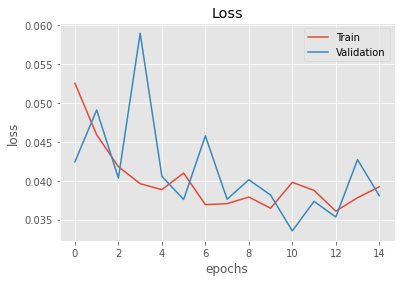

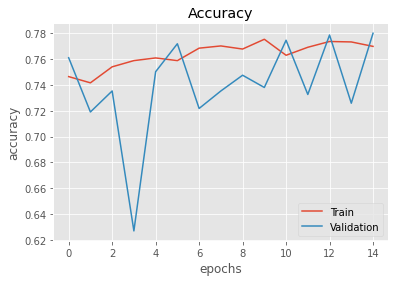

In [109]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.plot(train_loss)
plt.plot(validation_loss)
plt.title('Loss')
plt.legend(['Train', 'Validation'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.title('Accuracy')
plt.legend(['Train', 'Validation'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# Test Model (20)

In [117]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
accurate = 0.0
running_loss = 0.0
best_net.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = best_net(batch)
        running_loss += criterion(outputs, labels).item()
        _, p = torch.max(outputs, 1)
        accurate += (p == labels).squeeze().sum().item()
        outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(outputs)
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)
accuracy= accurate / len(test_loader.dataset)
loss =  running_loss / len(test_loader.dataset)
print(f'final accuracy: {accuracy}, finalloss: {loss}')

final accuracy: 0.7697929354445798, finalloss: 0.038182351025826455


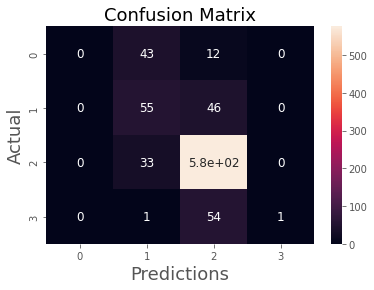

In [121]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns 

conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 12})

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()